# Compare Visualize Stock Set:

Maximum 8 stocks can be compared. 

## 1.1 Scrape Function: 

In [5]:
import pandas as pd
df_global_debug = pd.DataFrame([])

DEBUG_ME = False
def ScrapeSummerizeStockSet(stocklist_df,report_folder):
    import pandas as pd 
    from bs4 import BeautifulSoup
    import requests as rq
    import re
    import datetime
    import os
    import time

    # If the stock df does not contains Stock symbol and Url columns 
    # then retrun with error
    if not (stocklist_df.columns.isin(["Stock Symbol","Stock URL"]).all()):
        return "Error: Required column(s) is/are missing in stocklist_df."


    # local variables
    stock_name                  = ""
    stock_url                   = ""
    stock_sector                = ""
    stock_industry              = ""
    stock_url_type              = ""
    df_basic_info               = pd.DataFrame([]) # Basic Info
    df_top_ratios               = pd.DataFrame([]) # Top Ratios
    df_quaterly_results         = pd.DataFrame([]) # Quarterly Results
    df_profit_n_loss            = pd.DataFrame([]) # Profit & Loss
    df_compounded_sales_growth  = pd.DataFrame([]) # Compounded Sales Growth
    df_compounded_profit_growth = pd.DataFrame([]) # Compounded Profit Growth
    df_stock_price_cagr         = pd.DataFrame([]) # Stock Price CAGR
    df_return_on_equity         = pd.DataFrame([]) # Return on Equity
    df_balance_sheet            = pd.DataFrame([]) # Balance Sheet
    df_cash_flows               = pd.DataFrame([]) # Cash Flows
    df_ratios                   = pd.DataFrame([]) # Ratios
    df_shareholding_pattern     = pd.DataFrame([]) # Shareholding Pattern
    writer                      = None
    report_name                 = ""
    stock_reportpath            = ""

    c_df_basic_info               = pd.DataFrame([]) # Combined - Basic Info
    c_df_top_ratios               = pd.DataFrame([]) # Combined - Top Ratios
    c_df_quaterly_results         = pd.DataFrame([]) # Combined - Quarterly Results
    c_df_profit_n_loss            = pd.DataFrame([]) # Combined - Profit & Loss
    c_df_compounded_sales_growth  = pd.DataFrame([]) # Combined - Compounded Sales Growth
    c_df_compounded_profit_growth = pd.DataFrame([]) # Combined - Compounded Profit Growth
    c_df_stock_price_cagr         = pd.DataFrame([]) # Combined - Stock Price CAGR
    c_df_return_on_equity         = pd.DataFrame([]) # Combined - Return on Equity
    c_df_balance_sheet            = pd.DataFrame([]) # Combined - Balance Sheet
    c_df_cash_flows               = pd.DataFrame([]) # Combined - Cash Flows
    c_df_ratios                   = pd.DataFrame([]) # Combined - Ratios
    c_df_shareholding_pattern     = pd.DataFrame([]) # Combined - Shareholding Pattern
    
    if(DEBUG_ME): print("Info: Starting ScrapeStock()")
    if(DEBUG_ME): print("Info: Stock: ", stock_name)
    if(DEBUG_ME): print("Info: URL: ", stock_url)
    if(DEBUG_ME): print("Info: Report Folder: ", report_folder)

    if not os.path.exists(report_folder):
        os.makedirs(report_folder)
        if(DEBUG_ME): print("Info: Folder created: ",report_folder)

    ############### FOR LOOP START ################################################
    for index, row in stocklist_df.iterrows():

        stock_name = row["Stock Symbol"]
        stock_url = row["Stock URL"]
        
        if 'consolidated' in stock_url:
            stock_url_type = "consolidated"
            if(DEBUG_ME): print("Info: stock_url_type is : ",stock_url_type)
        elif 'consolidated' not in stock_url:
            stock_url_type = "standalone"
            if(DEBUG_ME): print("Info: stock_url_type is : ",stock_url_type)
        else:
            stock_url_type = ""
            if(DEBUG_ME): print("Info: stock_url_type is : ",stock_url_type)

        # Read the page: 
        if(DEBUG_ME): print("Info: Fetching URL...")
        response = rq.get(stock_url)
        if(DEBUG_ME): print("Info: URL Fetch completed")
        if(DEBUG_ME): print("Info: Response status code: ",response.status_code)
        time.sleep(1) # Seconds
	    
        tables = pd.read_html(response.content)
        if(DEBUG_ME): print("Info: Parsing Tables using Pandas. Number of Tables found: ",str(len(tables)))
	    
        if(DEBUG_ME): print("Info: beginning data parsing")
	    
        soup = BeautifulSoup(response.content, "html.parser")
        if(DEBUG_ME): print("Info: BSoup Object loaded")
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Parsing: Sector and industry: Start")
        temp0 = soup.findAll('p', attrs={'class':'sub'})[1].text
        temp0 = ' '.join(temp0.split())
	    
        if m := re.match(r'Sector:\s*([A-Za-z-\/ ]*)Industry:\s*([A-Za-z-\/ ]*)$', temp0):
            stock_sector = m.group(1).strip()
            stock_industry = m.group(2).strip()
            if(DEBUG_ME): print("Info: Parsing: Sector and industry: Found Sector:", stock_sector)
            if(DEBUG_ME): print("Info: Parsing: Sector and industry: Found Industry:", stock_industry)
        else: 
            stock_sector = 'Null'
            stock_industry = 'Null'
            if(DEBUG_ME): print("Error: Parsing: Failed to find Sector and Industry!")
        if(DEBUG_ME): print("Info: Parsing: Sector and industry: Finished")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Parsing: Start - Basic Info")
	    
        temp_1 = [{
        "Stockname": stock_name,
        "Stock Report Type": stock_url_type,
        "Stock Url": stock_url,
        "Sector": stock_sector,
        "Industry": stock_industry
        }]
	    
        df_basic_info = pd.DataFrame(temp_1)
	    
        if(DEBUG_ME): print("Info: Parsing: Finished - Basic Info")
        ## ---------------------------------------------------------

	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Parsing: Start - Top Ratios")
	    
        ul = soup.find("ul#top-ratios")  # Selector of top ratios
        lines = []
        for ul in soup.findAll('ul', id='top-ratios'):
            for li in ul.findAll('li'):
                li_parsed_text = li.text
                li_parsed_text = re.sub('[\s ]+', ' ', li_parsed_text)
                li_parsed_text = li_parsed_text.strip()
                #print(li_parsed_text)
                lines.append(li_parsed_text)
	    
        if(DEBUG_ME): print("Info: Parsing: Top Ratios: Cleaning up the To Ratios data line by line")
         # Line - 0
        if m := re.match(r"Market Cap ₹ ([0-9,.-]+) Cr.", lines[0]):
            line_0 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found Market Cap: ", line_0)
        else: 
            line_0 = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found Market Cap")
	    
        # Line - 1
        if m := re.match(r"Current Price ₹ ([0-9,.-]+)", lines[1]):
            line_1 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found Current Price: ", line_1)
        else: 
            line_1 = "NaN"
	    
        # Line - 2a
        if m := re.match(r"High \/ Low ₹ ([0-9,..-]+) \/ ([0-9,.]+)", lines[2]):
            line_2a = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found High: ", line_2a)
        else: 
            line_2a = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found High")
	    
        # Line - 2b
        if m := re.match(r"High \/ Low ₹ ([0-9,.-]+) \/ ([0-9,.]+)", lines[2]):
            line_2b = m.group(2).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found Low: ", line_2b)
        else: 
            line_2b = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found Low")
	    
        # Line - 3
        if m := re.match(r"Stock P\/E ([0-9,.-]+)", lines[3]):
            line_3 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found Low: ", line_3)
        else: 
            line_3 = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found __")
	    
        # Line - 4
        if m := re.match(r"Book Value ₹ ([0-9,.-]+)", lines[4]):
            line_4 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found Book Value: ", line_4)
        else: 
            line_4 = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found Book Value")
	    
        # Line - 5
        if m := re.match(r"Dividend Yield ([0-9,.-]+) %", lines[5]):
            line_5 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found Dividend Yield: ", line_5)
        else: 
            line_5 = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found Dividend Yield")
	    
        # Line - 6
        if m := re.match(r"ROCE ([0-9,.-]+) %", lines[6]):
            line_6 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found ROCE: ", line_6)
        else: 
            line_6 = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found ROCE")
	    
        # Line - 7
        if m := re.match(r"ROE ([0-9,.-]+) %", lines[7]):
            line_7 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found ROE: ", line_7)
        else: 
            line_7 = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found ROE")
	    
        # Line - 8
        if m := re.match(r"Face Value ₹ ([0-9,.-]+)", lines[8]):
            line_8 = m.group(1).replace(',','')
            if(DEBUG_ME): print("Info: Parsing: Top Ratios: Found Face Value: ", line_8)
        else: 
            line_8 = "NaN"
            if(DEBUG_ME): print("Error: Parsing: Top Ratios: Not Found Face Value")
	    
        if(DEBUG_ME): print("Info: Parsing: Top Ratios: Preparing Dataframe")
        temp_2 = [{
        "Stockname":stock_name,
        "Market Cap in Cores Rupees":line_0,
        "Current Price in Rupees":line_1,
        "High in Rupees":line_2a,
        "Low in Rupees":line_2b,
        "Stock PE":line_3,
        "Book Value in Rupees":line_4,
        "Dividend Yield %": line_5,
        "ROCE %":line_6,
        "ROE %":line_7,
        "Face Value in Rupees":line_8,
        }]
	    
        df_top_ratios = pd.DataFrame(temp_2)
        if(DEBUG_ME): print("Info: Parsing: Top Ratios: Done Dataframe for Top Ratios")
	    
        if(DEBUG_ME): print("Info: Parsing: Finished - Top Ratios")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Parsing: Start - All Pandas Tables")
        
        df_quaterly_results         = tables[0] # Quarterly Results
        df_profit_n_loss            = tables[1] # Profit & Loss
        df_compounded_sales_growth  = tables[2] # Compounded Sales Growth
        df_compounded_profit_growth = tables[3] # Compounded Profit Growth
        df_stock_price_cagr         = tables[4] # Stock Price CAGR
        df_return_on_equity         = tables[5] # Return on Equity
        df_balance_sheet            = tables[6] # Balance Sheet
        df_cash_flows               = tables[7] # Cash Flows
        df_ratios                   = tables[8] # Ratios
        df_shareholding_pattern     = tables[9] # Shareholding Pattern
	    
        if(DEBUG_ME): print("Info: Parsing: Finished - All Pandas Tables")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Cleaning: Start - All Pandas Tables")
        
        # Cleanup table: Quarterly Results
        df_quaterly_results.rename(columns={'Unnamed: 0':'Quarterly Results'}, inplace=True)
        df_quaterly_results.replace(u"\u00A0\+", "", regex=True,inplace=True)
        if(DEBUG_ME): print("Info: Cleaning: Done - Quarterly Results")
        
        # Cleanup table: Profit & Loss
        df_profit_n_loss.rename(columns={'Unnamed: 0':'Profit and Loss'}, inplace=True)
        df_profit_n_loss.replace(u"\u00A0\+", "", regex=True,inplace=True)
        if(DEBUG_ME): print("Info: Cleaning: Done - Profit & Loss")
	    
        # Cleanup table: Compounded Sales Growth
        df_compounded_sales_growth.replace(":", "", regex=True,inplace=True) 
        
        # Cleanup table: Compounded Profit Growth
        df_compounded_profit_growth.replace(":", "", regex=True,inplace=True) 
        
        # Cleanup table: Stock Price CAGR
        df_stock_price_cagr.replace(":", "", regex=True,inplace=True) 
        
        # Cleanup table: Return on Equity
        df_return_on_equity.replace(":", "", regex=True,inplace=True) 
        
        # Cleanup table: Balance Sheet
        df_balance_sheet.rename(columns={'Unnamed: 0':'Balance Sheet'}, inplace=True)
        df_balance_sheet.replace(u"\u00A0\+", "", regex=True,inplace=True) 
        
        # Cleanup table: Cash Flows
        df_cash_flows.rename(columns={'Unnamed: 0':'Cash Flows'}, inplace=True)
        df_cash_flows.replace(u"\u00A0\+", "", regex=True,inplace=True) 
        
        # Cleanup table: Ratios
        df_ratios.rename(columns={'Unnamed: 0':'Ratios'}, inplace=True)
        
        # Cleanup table: Shareholding Pattern
        df_shareholding_pattern.rename(columns={'Unnamed: 0':'Shareholding Pattern'}, inplace=True)
        df_shareholding_pattern.replace(u"\u00A0\+", "", regex=True,inplace=True)
	    
        if(DEBUG_ME): print("Info: Cleaning: Finished - All Pandas Tables")
        ## ---------------------------------------------------------
	    
        ## =================================================================================
        ## Dataframe contains space, non-numeric and percent sign so those should be removed
        ## =================================================================================
        
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_top_ratios")
        # First col is texual, rest are numeric
        #df_top_ratios[df_top_ratios.columns[1:]] = df_top_ratios[df_top_ratios.columns[1:]].apply(pd.to_numeric)
	    
        for col in df_top_ratios.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_top_ratios[col] = df_top_ratios[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_top_ratios[col] = df_top_ratios[col].apply(pd.to_numeric)
        # Stockname column already added
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_top_ratios.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_top_ratios")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_quaterly_results")
        # First col is texual, rest are numeric
        for col in df_quaterly_results.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_quaterly_results[col] = df_quaterly_results[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            #df_global_debug[col] = df_quaterly_results[col]
            df_quaterly_results[col] = df_quaterly_results[col].apply(pd.to_numeric)
        
        # Add and insert 'Stockname' column at second position
        df_quaterly_results['Stockname'] = stock_name
        temp_col = df_quaterly_results.pop("Stockname")
        df_quaterly_results.insert(1, "Stockname", temp_col)
        
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_quaterly_results.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_quaterly_results")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_profit_n_loss")
        # First col is texual, rest are numeric
        for col in df_profit_n_loss.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_profit_n_loss[col] = df_profit_n_loss[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_profit_n_loss[col] = df_profit_n_loss[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_profit_n_loss['Stockname'] = stock_name
        temp_col = df_profit_n_loss.pop("Stockname")
        df_profit_n_loss.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_profit_n_loss.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_profit_n_loss")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_compounded_sales_growth")
        # First col is texual, rest are numeric
        for col in df_compounded_sales_growth.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_compounded_sales_growth[col] = df_compounded_sales_growth[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_compounded_sales_growth[col] = df_compounded_sales_growth[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_compounded_sales_growth['Stockname'] = stock_name
        temp_col = df_compounded_sales_growth.pop("Stockname")
        df_compounded_sales_growth.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_compounded_sales_growth.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_compounded_sales_growth")
        ## ---------------------------------------------------------
	    
        
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_compounded_profit_growth")
        # First col is texual, rest are numeric
        for col in df_compounded_profit_growth.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_compounded_profit_growth[col] = df_compounded_profit_growth[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_compounded_profit_growth[col] = df_compounded_profit_growth[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_compounded_profit_growth['Stockname'] = stock_name
        temp_col = df_compounded_profit_growth.pop("Stockname")
        df_compounded_profit_growth.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_compounded_profit_growth.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_compounded_profit_growth")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_stock_price_cagr")
        # First col is texual, rest are numeric
        for col in df_stock_price_cagr.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_stock_price_cagr[col] = df_stock_price_cagr[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_stock_price_cagr[col] = df_stock_price_cagr[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_stock_price_cagr['Stockname'] = stock_name
        temp_col = df_stock_price_cagr.pop("Stockname")
        df_stock_price_cagr.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_stock_price_cagr.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_stock_price_cagr")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_return_on_equity")
        # First col is texual, rest are numeric
        for col in df_return_on_equity.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_return_on_equity[col] = df_return_on_equity[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_return_on_equity[col] = df_return_on_equity[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_return_on_equity['Stockname'] = stock_name
        temp_col = df_return_on_equity.pop("Stockname")
        df_return_on_equity.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_return_on_equity.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_return_on_equity")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_balance_sheet")
        # First col is texual, rest are numeric
        for col in df_balance_sheet.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            ## CAUTION: Converting value to string!
            df_balance_sheet[col] = df_balance_sheet[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_balance_sheet[col] = df_balance_sheet[col].apply(pd.to_numeric)
            
        # Add and insert 'Stockname' column at second position
        df_balance_sheet['Stockname'] = stock_name
        temp_col = df_balance_sheet.pop("Stockname")
        df_balance_sheet.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_balance_sheet.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_balance_sheet")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_cash_flows")
        # First col is texual, rest are numeric
        for col in df_cash_flows.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_cash_flows[col] = df_cash_flows[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_cash_flows[col] = df_cash_flows[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_cash_flows['Stockname'] = stock_name
        temp_col = df_cash_flows.pop("Stockname")
        df_cash_flows.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_cash_flows.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_cash_flows")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_ratios")
        # First col is texual, rest are numeric
        for col in df_ratios.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_ratios[col] = df_ratios[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_ratios[col] = df_ratios[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_ratios['Stockname'] = stock_name
        temp_col = df_ratios.pop("Stockname")
        df_ratios.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_ratios.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_ratios")
        ## ---------------------------------------------------------
	    
        ## ---------------------------------------------------------
        if(DEBUG_ME): print("Info: Data Transform: Start - df_shareholding_pattern")
        # First col is texual, rest are numeric
        for col in df_shareholding_pattern.columns[1:]:
            # Remove comma, percent sign and Empty value with NaN
            df_shareholding_pattern[col] = df_shareholding_pattern[col].astype(str).str.replace(',','').str.rstrip('%').replace('nan','NaN').replace('','NaN').replace("NaN", pd.NA)
            df_shareholding_pattern[col] = df_shareholding_pattern[col].apply(pd.to_numeric)
	    
        # Add and insert 'Stockname' column at second position
        df_shareholding_pattern['Stockname'] = stock_name
        temp_col = df_shareholding_pattern.pop("Stockname")
        df_shareholding_pattern.insert(1, "Stockname", temp_col)
	    
        if(DEBUG_ME): print("Info: Data Transform: Outcome: \n",df_shareholding_pattern.info())
        if(DEBUG_ME): print("Info: Data Transform: Done - df_shareholding_pattern")
        ## ---------------------------------------------------------


        ## ----------------------------------------------------------
        ## Finally Concat all the dataframe
        ## ----------------------------------------------------------

        c_df_basic_info = pd.concat([c_df_basic_info, df_basic_info], ignore_index=True, sort=False)
        c_df_top_ratios = pd.concat([c_df_top_ratios, df_top_ratios], ignore_index=True, sort=False)
        c_df_quaterly_results = pd.concat([c_df_quaterly_results, df_quaterly_results], ignore_index=True, sort=False)
        c_df_profit_n_loss = pd.concat([c_df_profit_n_loss, df_profit_n_loss], ignore_index=True, sort=False)
        c_df_compounded_sales_growth = pd.concat([c_df_compounded_sales_growth, df_compounded_sales_growth], ignore_index=True, sort=False)
        c_df_compounded_profit_growth = pd.concat([c_df_compounded_profit_growth, df_compounded_profit_growth], ignore_index=True, sort=False)
        c_df_stock_price_cagr = pd.concat([c_df_stock_price_cagr, df_stock_price_cagr], ignore_index=True, sort=False)
        c_df_return_on_equity = pd.concat([c_df_return_on_equity, df_return_on_equity], ignore_index=True, sort=False)
        c_df_balance_sheet = pd.concat([c_df_balance_sheet, df_balance_sheet], ignore_index=True, sort=False)
        c_df_cash_flows = pd.concat([c_df_cash_flows, df_cash_flows], ignore_index=True, sort=False)
        c_df_ratios = pd.concat([c_df_ratios, df_ratios], ignore_index=True, sort=False)
        c_df_shareholding_pattern = pd.concat([c_df_shareholding_pattern, df_shareholding_pattern], ignore_index=True, sort=False)

        ################################ End of for loop #############################################

 
    
    ## ---------------------------------------------------------
    if(DEBUG_ME): print("Info: Saving Report...")

    sheet_names = ["Basic Info", "Top Ratios","Quarterly Results", "Profit & Loss", "Compounded Sales Growth", "Compounded Profit Growth", 
                   "Stock Price CAGR", "Return on Equity", "Balance Sheet", "Cash Flows", "Ratios", "Shareholding Pattern"]
    dataframes  = [c_df_basic_info, c_df_top_ratios, c_df_quaterly_results, 
                   c_df_profit_n_loss, c_df_compounded_sales_growth, c_df_compounded_profit_growth, 
                   c_df_stock_price_cagr, c_df_return_on_equity, c_df_balance_sheet, 
                   c_df_cash_flows, c_df_ratios, c_df_shareholding_pattern]

    
    report_name = "SummaryReport-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".xlsx"
    stock_reportpath = report_folder + "/" + report_name
    
    writer = pd.ExcelWriter(stock_reportpath, engine='xlsxwriter')
    
    for i, frame in enumerate(dataframes):
        frame.to_excel(writer, sheet_name = sheet_names[i], index=False)
    writer.close()
    writer.handles = None

    if(DEBUG_ME): print("Info: Report saved successfully: ", stock_reportpath)
    ## ---------------------------------------------------------

    
    return stock_reportpath

## 1.2 Comparative Visualize Function:

In [33]:
DEBUG_ME = False

# Visualize single stock function
def CompareVisualizeStockSet(stock_excel_filepath,output_folder):
    import pandas as pd 
    from bs4 import BeautifulSoup
    import requests as rq
    import re
    import datetime
    import os
    import time

    import plotly.offline as pyo 
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # local variables
    all_figures = []
    fig01 = go.Figure()
    fig02 = go.Figure()
    fig03 = go.Figure()
    fig04 = go.Figure()
    fig05 = go.Figure()
    fig06 = go.Figure()
    fig07 = go.Figure()
    fig08 = go.Figure()
    fig09 = go.Figure()
    fig10 = go.Figure()
    fig11 = go.Figure()
    fig12 = go.Figure()
    fig13 = go.Figure()
    fig14 = go.Figure()
    fig15 = go.Figure()

    # https://colorkit.co/palettes/8-colors/
    color_set = {
        "dark_red"       : "#6f1926",
        "red"            : "#de324c",
        "orange"         : "#f4895f",
        "yellow"         : "#f8e16f",
        "bright_green"   : "#8bc34a",
        "dark_green"     : "#009688", #"#318a01",
        "blue"           : "#369acc",
        "sky_blue"       : "#80d9ff",
        "dark_blue"      : "#0057e5",
        "violet"         : "#9656a2",
        "purple"         : "#7b4fff",
        "black"          : "#212020",
        "gray"           : "#777675"
    }
    
    df_top_ratios               = pd.DataFrame([]) # Top Ratios
    df_quaterly_results         = pd.DataFrame([]) # Quarterly Results
    df_profit_n_loss            = pd.DataFrame([]) # Profit & Loss
    df_compounded_sales_growth  = pd.DataFrame([]) # Compounded Sales Growth
    df_compounded_profit_growth = pd.DataFrame([]) # Compounded Profit Growth
    df_stock_price_cagr         = pd.DataFrame([]) # Stock Price CAGR
    df_return_on_equity         = pd.DataFrame([]) # Return on Equity
    df_balance_sheet            = pd.DataFrame([]) # Balance Sheet
    df_cash_flows               = pd.DataFrame([]) # Cash Flows
    df_ratios                   = pd.DataFrame([]) # Ratios
    df_shareholding_pattern     = pd.DataFrame([]) # Shareholding Pattern

    stock_name                  = ""
    stock_url                   = ""
    stock_url_type              = ""
    stock_sector                = ""
    stock_industry              = ""
    stock_marketcap             = ""
    
    writer                      = None
    html_report_name            = ""
    stock_html_reportpath       = ""
    

    if(DEBUG_ME): print("Info: Starting CompareVisualizeStockSet()")
    if(DEBUG_ME): print("Info: Excel File of the stocks to load : ", stock_excel_filepath)

    # Load Excel File
    if(DEBUG_ME): print("Info: Loading Excel File")
    xls = pd.ExcelFile(stock_excel_filepath)

    df_basic_info               = pd.read_excel(xls, "Basic Info") # Top Ratios
    df_top_ratios               = pd.read_excel(xls, "Top Ratios") # Top Ratios
    df_quaterly_results         = pd.read_excel(xls, "Quarterly Results") # Quarterly Results
    df_profit_n_loss            = pd.read_excel(xls, "Profit & Loss") # Profit & Loss
    df_compounded_sales_growth  = pd.read_excel(xls, "Compounded Sales Growth") # Compounded Sales Growth
    df_compounded_profit_growth = pd.read_excel(xls, "Compounded Profit Growth") # Compounded Profit Growth
    df_stock_price_cagr         = pd.read_excel(xls, "Stock Price CAGR") # Stock Price CAGR
    df_return_on_equity         = pd.read_excel(xls, "Return on Equity") # Return on Equity
    df_balance_sheet            = pd.read_excel(xls, "Balance Sheet") # Balance Sheet
    df_cash_flows               = pd.read_excel(xls, "Cash Flows") # Cash Flows
    df_ratios                   = pd.read_excel(xls, "Ratios") # Ratios
    df_shareholding_pattern     = pd.read_excel(xls, "Shareholding Pattern") # Shareholding Pattern

    xls.close()

    if(DEBUG_ME): print("Info: Loaded all dataframes")

    ## ==================================================================================================================
    ## Chart-01: Fig01 - Top Ratios - Market Cap
    ## ==================================================================================================================
    x  = df_top_ratios['Stockname']
    y1 = df_top_ratios['Market Cap in Cores Rupees']
    
    fig01.add_trace( go.Bar(x=x, y=y1, name='Market Cap in Cores Rupees', marker_color =color_set.get("dark_blue")))
    plot_title = '<b>Market Cap comparison:</b>'
    
    fig01.update_layout(title=plot_title,xaxis_title='Stockname', yaxis_title='Rs. in Crores')
    # pyo.plot(fig01, filename="temp-plot.html")
    #fig01.show()
    all_figures.append(fig01)
    if(DEBUG_ME): print("Info: Chart-01 Generated")

    ## ==================================================================================================================
    ## Chart-01: Fig02 - Top Ratios - All other
    ## ==================================================================================================================
    x  = df_top_ratios['Stockname']
    y1 = df_top_ratios['Face Value in Rupees']
    y2 = df_top_ratios['Stock PE']
    y3 = df_top_ratios['Book Value in Rupees']
    y4 = df_top_ratios['Dividend Yield %']
    y5 = df_top_ratios['ROCE %']
    y6 = df_top_ratios['ROE %']

    fig02 = make_subplots(
        rows=2,
        cols=3,
        specs=[
            [{"type": "bar"}, {"type": "bar"},{"type": "bar"}],
            [{"type": "bar"}, {"type": "bar"},{"type": "bar"}],
        ],
       subplot_titles=('Face Value in Rupees', 'Stock PE', 
                       'Book Value in Rupees', 'Dividend Yield %', 'ROCE %', 'ROE %')
    )
    
    fig02.add_trace( go.Bar(x=x, y=y1, name='Face Value in Rupees', marker_color =color_set.get("gray")), row=1, col=1)
    fig02.add_trace( go.Bar(x=x, y=y2, name='PE Ratio', marker_color =color_set.get("red")), row=1, col=2)
    fig02.add_trace( go.Bar(x=x, y=y3, name='Book Value in Rupees', marker_color =color_set.get("violet")), row=1, col=3)
    fig02.add_trace( go.Bar(x=x, y=y4, name='Dividend Yield %', marker_color =color_set.get("dark_green")), row=2, col=1)
    fig02.add_trace( go.Bar(x=x, y=y5, name='ROCE %', marker_color =color_set.get("blue")), row=2, col=2)
    fig02.add_trace( go.Bar(x=x, y=y6, name='ROE %', marker_color =color_set.get("bright_green")), row=2, col=3)

    fig02['layout']['yaxis']['title']='rupees'
    fig02['layout']['yaxis2']['title']='multiples'
    fig02['layout']['yaxis3']['title']='rupees'
    fig02['layout']['yaxis4']['title']='%'
    fig02['layout']['yaxis5']['title']='%'
    fig02['layout']['yaxis6']['title']='%'

    plot_title = '<b>Common parameters:</b>'

    fig02.update_layout(title=plot_title)
    
    #pyo.plot(fig02, filename="temp-plot.html")
    #fig02.show()
    all_figures.append(fig02)
    if(DEBUG_ME): print("Info: Chart-02 Generated")

    ## ==================================================================================================================
    ## Chart-03: Fig03 - Quaterly Results - All
    ## ==================================================================================================================

    df_quaterly_results.drop(df_quaterly_results[df_quaterly_results['Quarterly Results'] == 'Raw PDF'].index, inplace=True)
    df = df_quaterly_results

    plot_title = '<b>Quarterly Results comparison:</b>'

    fig03.update_layout(title=plot_title, xaxis_title='Quarter', yaxis_title='Respective units')

    x = df_quaterly_results.columns[2:]

    # Add traces for each metric
    for result in df['Quarterly Results'].unique():
        for stock in df['Stockname'].unique():
            fig03.add_trace(go.Bar(x=x,y=df[(df['Stockname'] == stock) & (df['Quarterly Results'] == result)].iloc[0, 2:],name=f'{stock} {result}'))

    # Add buttons to toggle the visibility
    buttons = [{'label': label, 'method': 'update',
                'args': [{'visible': [label in trace.name for trace in fig03.data]}]
               }for label in df['Quarterly Results'].unique()
              ]

    updatemenus = [{'buttons': buttons, 'direction': "down", 'showactive': True, }]

    # update layout with buttons, and show the figure
    fig03.update_layout(updatemenus=updatemenus)
    #fig03.show()
    #pyo.plot(fig01, filename='MultiCategoryPlot.html')
   
    all_figures.append(fig03)
    if(DEBUG_ME): print("Info: Chart-03 Generated")


    ## ==================================================================================================================
    ## Chart-04: Fig04 - Profit and Loss - All
    ## ==================================================================================================================
    df = df_profit_n_loss
    x = df.columns[2:]

    plot_title = '<b>Profit & Loss comparison:</b>'

    fig04.update_layout(title=plot_title, xaxis_title='Year', yaxis_title='Respective units')

    # Add traces for each metric
    for result in df['Profit and Loss'].unique():
        for stock in df['Stockname'].unique():
            fig04.add_trace(go.Bar(x=x,y=df[(df['Stockname'] == stock) & (df['Profit and Loss'] == result)].iloc[0, 2:],name=f'{stock} {result}'))

    # Add buttons to toggle the visibility
    buttons = [{'label': label, 'method': 'update',
                'args': [{'visible': [label in trace.name for trace in fig04.data]}]
               }for label in df['Profit and Loss'].unique()
              ]

    updatemenus = [{'buttons': buttons, 'direction': "down", 'showactive': True, }]

    # update layout with buttons, and show the figure
    fig04.update_layout(updatemenus=updatemenus)
    #fig04.show()
    #pyo.plot(fig04, filename='plot.html')
   
    all_figures.append(fig04)
    if(DEBUG_ME): print("Info: Chart-04 Generated")

    ## ==================================================================================================================
    ## Chart-05: Fig05 - Compounded sales growth - All
    ## ==================================================================================================================

    ## ==================================================================================================================
    ## Chart-06: Fig06 - Compounded profit growth - All
    ## ==================================================================================================================

    ## ==================================================================================================================
    ## Chart-07: Fig07 - Return on equity - All
    ## ==================================================================================================================

    ## ==================================================================================================================
    ## Chart-08: Fig08 - Stock price cagr - All
    ## ==================================================================================================================

    ## ==================================================================================================================
    ## Chart-09: Fig09 - Balance sheet - All
    ## ==================================================================================================================
    df = df_balance_sheet
    x = df.columns[2:]

    plot_title = '<b>Balance sheet comparison:</b>'

    fig09.update_layout(title=plot_title, xaxis_title='Year', yaxis_title='Respective units')

    # Add traces for each metric
    for result in df['Balance Sheet'].unique():
        for stock in df['Stockname'].unique():
            fig09.add_trace(go.Bar(x=x,y=df[(df['Stockname'] == stock) & (df['Balance Sheet'] == result)].iloc[0, 2:],name=f'{stock} {result}'))

    # Add buttons to toggle the visibility
    buttons = [{'label': label, 'method': 'update',
                'args': [{'visible': [label in trace.name for trace in fig09.data]}]
               }for label in df['Balance Sheet'].unique()
              ]

    updatemenus = [{'buttons': buttons, 'direction': "down", 'showactive': True, }]

    # update layout with buttons, and show the figure
    fig09.update_layout(updatemenus=updatemenus)
    #fig09.show()
    #pyo.plot(fig09, filename='plot.html')
   
    all_figures.append(fig09)
    if(DEBUG_ME): print("Info: Chart-09 Generated")

    ## ==================================================================================================================
    ## Chart-10: Fig10 - Cash Flows - All
    ## ==================================================================================================================
    df = df_cash_flows
    x = df.columns[2:]

    plot_title = '<b>Cashflows comparison:</b>'

    fig10.update_layout(title=plot_title, xaxis_title='Year', yaxis_title='Respective units')

    # Add traces for each metric
    for result in df['Cash Flows'].unique():
        for stock in df['Stockname'].unique():
            fig10.add_trace(go.Bar(x=x,y=df[(df['Stockname'] == stock) & (df['Cash Flows'] == result)].iloc[0, 2:],name=f'{stock} {result}'))

    # Add buttons to toggle the visibility
    buttons = [{'label': label, 'method': 'update',
                'args': [{'visible': [label in trace.name for trace in fig10.data]}]
               }for label in df['Cash Flows'].unique()
              ]

    updatemenus = [{'buttons': buttons, 'direction': "down", 'showactive': True, }]

    # update layout with buttons, and show the figure
    fig10.update_layout(updatemenus=updatemenus)
    #fig10.show()
    #pyo.plot(fig10, filename='plot.html')
   
    all_figures.append(fig10)
    if(DEBUG_ME): print("Info: Chart-10 Generated")


    ## ==================================================================================================================
    ## Chart-11: Fig11 - Ratios - All
    ## ==================================================================================================================
    df = df_ratios
    x = df.columns[2:]

    plot_title = '<b>Operational Ratios comparison:</b>'

    fig11.update_layout(title=plot_title, xaxis_title='Year', yaxis_title='Respective units')

    # Add traces for each metric
    for result in df['Ratios'].unique():
        for stock in df['Stockname'].unique():
            fig11.add_trace(go.Bar(x=x,y=df[(df['Stockname'] == stock) & (df['Ratios'] == result)].iloc[0, 2:],name=f'{stock} {result}'))

    # Add buttons to toggle the visibility
    buttons = [{'label': label, 'method': 'update',
                'args': [{'visible': [label in trace.name for trace in fig11.data]}]
               }for label in df['Ratios'].unique()
              ]

    updatemenus = [{'buttons': buttons, 'direction': "down", 'showactive': True, }]

    # update layout with buttons, and show the figure
    fig11.update_layout(updatemenus=updatemenus)
    #fig11.show()
    #pyo.plot(fig11, filename='plot.html')
   
    all_figures.append(fig11)
    if(DEBUG_ME): print("Info: Chart-11 Generated")


    ## ==================================================================================================================
    ## Chart-12: Fig12 - Shareholding - All
    ## ==================================================================================================================

    df = df_shareholding_pattern
    x = df.columns[2:]

    print(df_shareholding_pattern)

    plot_title = '<b>Shareholding pattern comparison:</b>'

    fig12.update_layout(title=plot_title, xaxis_title='Year', yaxis_title='Respective units')

    # Add traces for each metric
    for result in df['Shareholding Pattern'].unique():
        for stock in df['Stockname'].unique():
            if not df[ (df['Stockname'] == stock) & (df['Shareholding Pattern'] == result) ].empty:
                fig12.add_trace(go.Bar(x=x,y=df[(df['Stockname'] == stock) & (df['Shareholding Pattern'] == result)].iloc[0, 2:],name=f'{stock} {result}'))

    # Add buttons to toggle the visibility
    buttons = [{'label': label, 'method': 'update',
                'args': [{'visible': [label in trace.name for trace in fig12.data]}]
               }for label in df['Shareholding Pattern'].unique()
              ]

    updatemenus = [{'buttons': buttons, 'direction': "down", 'showactive': True, }]

    # update layout with buttons, and show the figure
    fig12.update_layout(updatemenus=updatemenus)
    #fig12.show()
    #pyo.plot(fig12, filename='plot.html')
   
    all_figures.append(fig12)
    if(DEBUG_ME): print("Info: Chart-12 Generated")


    ## ==================================================================================================================
    ## Finally, Export all figures to HTML File
    ## ==================================================================================================================

    # Optionally, display all figures
    if(DEBUG_ME): 
        for fig in all_figures: 
            fig.show()
            
    for fig in all_figures: 
            fig.show()

    #stock_html_reportpath =  output_folder + "/" + stock_name + "-" + stock_url_type + "-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+".html"

    # with open(stock_html_reportpath, 'a') as f:
    #     for fig in all_figures:
    #         f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
            
    # if(DEBUG_ME): print("Info: All charts saved to: ", stock_html_reportpath)

    
    
    return stock_html_reportpath

## 1.2 Function Call: 

   Shareholding Pattern Stockname   Sep 2021   Dec 2021   Mar 2022   Jun 2022  \
0             Promoters  UNITDSPR      56.73      56.73      56.73      56.73   
1                  FIIs  UNITDSPR      19.08      17.94      17.73      16.76   
2                  DIIs  UNITDSPR       9.65      10.41      10.41      10.85   
3            Government  UNITDSPR       0.01       0.01       0.01       0.01   
4                Public  UNITDSPR      14.53      14.92      15.12      15.65   
5   No. of Shareholders  UNITDSPR  191699.00  234926.00  241111.00  252264.00   
6             Promoters       UBL      72.71      72.71      72.71      72.71   
7                  FIIs       UBL       9.78       9.61       8.70       7.69   
8                  DIIs       UBL      10.49      10.90      11.92      13.01   
9            Government       UBL       1.16       1.16       1.16       1.16   
10               Public       UBL       5.86       5.62       5.51       5.43   
11  No. of Shareholders     

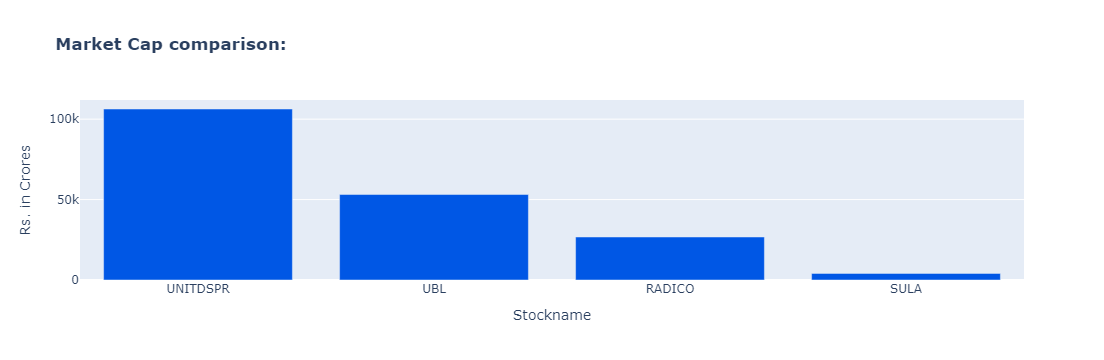

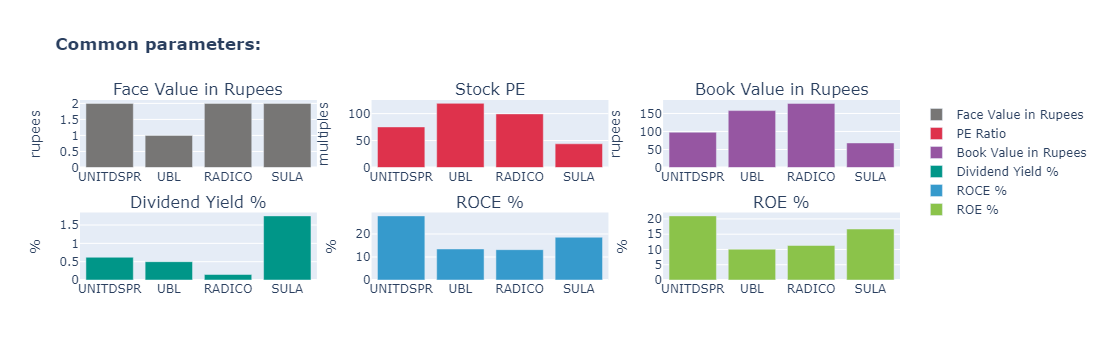

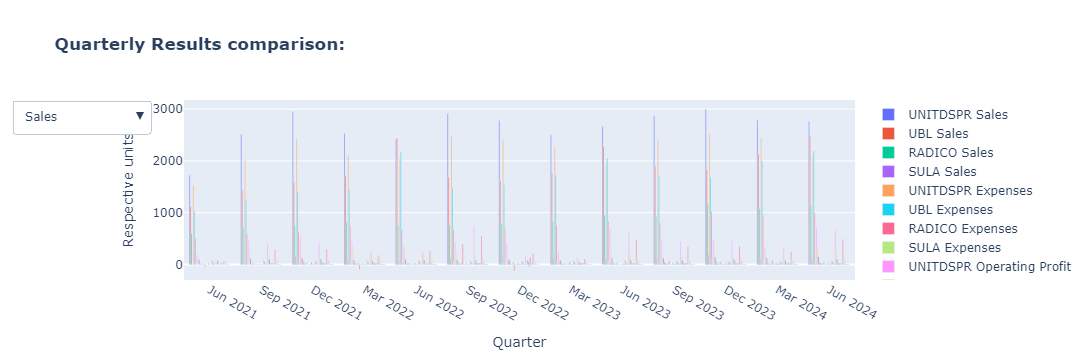

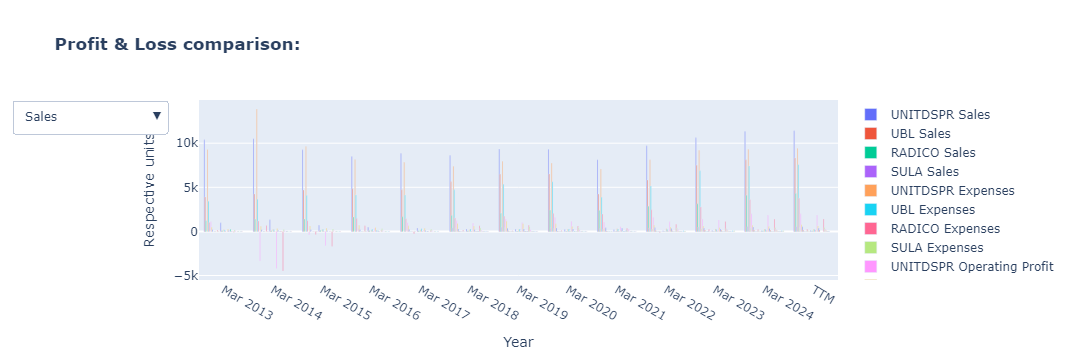

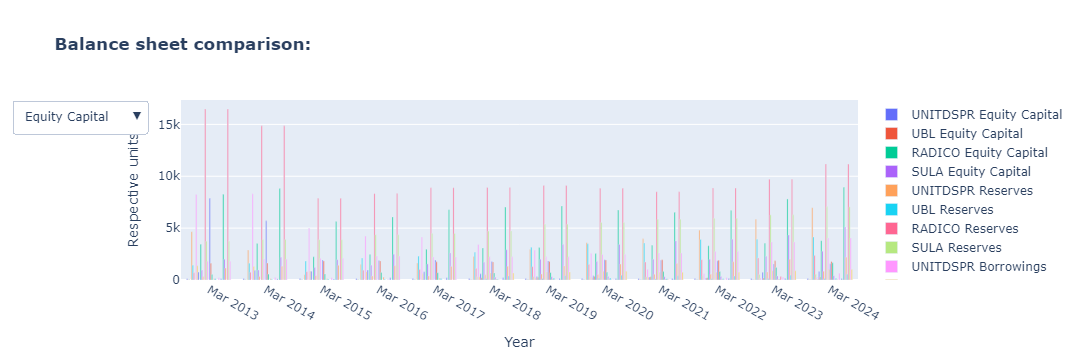

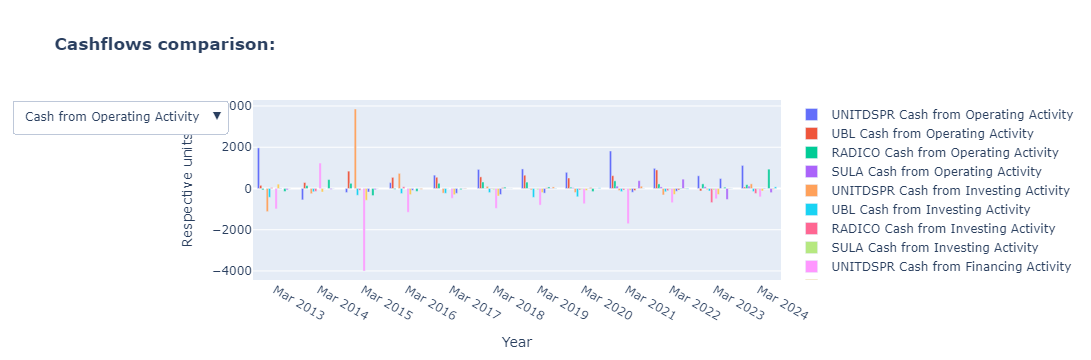

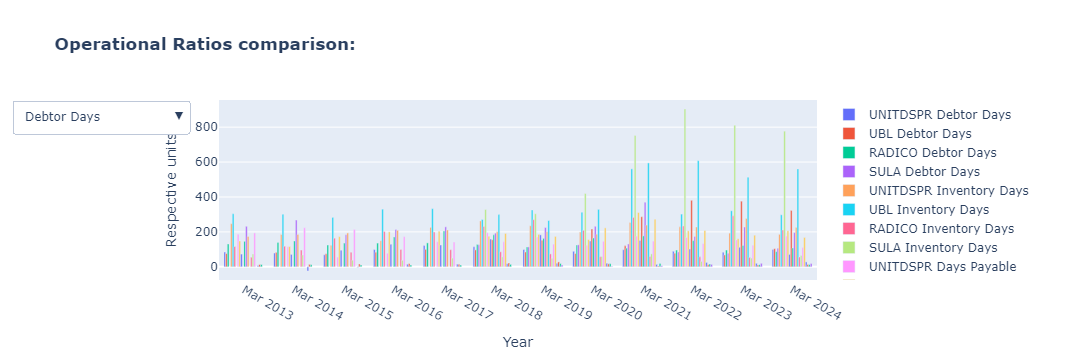

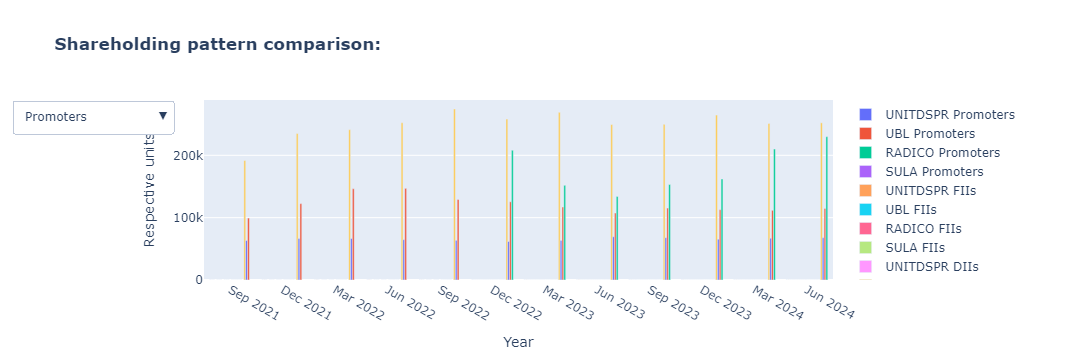

../Output/RawReports-05-ScrapeSummerizeStockSet/SummaryReport-20240907-115150.xlsx



In [34]:
import pandas as pd
input_csv_file = "../Input/stocks-compare-liquor.csv"

stocklist_df = pd.read_csv(input_csv_file)

report_folder = "../Output/RawReports-05-ScrapeSummerizeStockSet"

summary_report = ScrapeSummerizeStockSet(stocklist_df,report_folder)

visual_report = CompareVisualizeStockSet(summary_report,report_folder)

print(summary_report)
print(visual_report)